In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/users-vs-bots-classification/bots_vs_users.csv


# Importing Library and Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('/kaggle/input/users-vs-bots-classification/bots_vs_users.csv')

# View shape and first few rows
print("Shape of dataset:", df.shape)

Shape of dataset: (5874, 60)


# Preprocessing

In [4]:
df.head()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   object 
 1   has_birth_date              5874 non-null   object 
 2   has_photo                   5874 non-null   object 
 3   can_post_on_wall            5874 non-null   object 
 4   can_send_message            5874 non-null   object 
 5   has_website                 5874 non-null   object 
 6   gender                      5874 non-null   object 
 7   has_short_name              5874 non-null   object 
 8   has_first_name              5874 non-null   object 
 9   has_last_name               5874 non-null   object 
 10  access_to_closed_profile    5874 non-null   object 
 11  is_profile_closed           5874 non-null   object 
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

In [6]:
df.describe()

,target,posts_count,avg_likes,links_ratio,hashtags_ratio,avg_keywords,avg_text_length,attachments_ratio,avg_comments,reposts_ratio,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness
count,5874.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000
mean,0.500000,18.629044,19.552487,0.156463,0.143918,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
std,0.500043,4.231994,41.954881,0.202730,0.187085,11.278711,746.728130,0.170084,2.461709,0.397830,0.033136,1617.635460,154.970296,0.009545,0.229815
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.400000,0.000000,0.000000,1.100000,86.600000,0.850000,0.000000,0.050000,0.000000,9.125000,1.980000,0.000000,0.580000
50%,0.500000,20.000000,7.600000,0.100000,0.050000,3.400000,267.800000,0.950000,0.000000,0.300000,0.000000,268.950000,30.950000,0.000000,0.710000
75%,1.000000,20.000000,26.075000,0.200000,0.200000,7.850000,616.850000,1.000000,0.200000,0.900000,0.000000,746.050000,89.480000,0.000000,0.830000
max,1.000000,20.000000,894.900000,1.000000,1.000000,61.600000,5841.250000,1.000000,64.050000,1.000000,0.950000,41415.700000,2866.590000,0.300000,1.000000


In [7]:
df.isnull().sum().sort_values(ascending=True).head(10)

has_domain              0
has_activities          0
has_music               0
can_add_as_friend       0
can_invite_to_group     0
occupation_type_work    0
is_blacklisted          0
has_career              0
has_military_service    0
has_hometown            0
dtype: int64

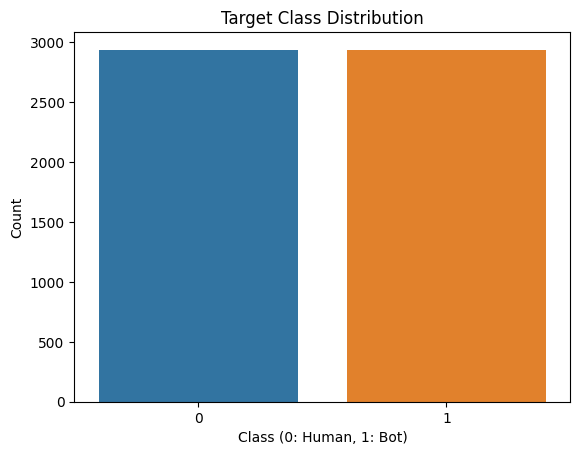

target
1    50.0
0    50.0
Name: proportion, dtype: float64

In [8]:
# Distribution of target variable (0 = human, 1 = bot)
sns.countplot(x='target', data=df)
plt.title('Target Class Distribution')
plt.xlabel('Class (0: Human, 1: Bot)')
plt.ylabel('Count')
plt.show()

# Display counts and percentages
df['target'].value_counts(normalize=True) * 100

In [9]:
# Separate numeric and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove the target column from numerical_cols
numerical_cols.remove('target')

print("Number of numerical features:", len(numerical_cols))
print("Number of categorical features:", len(categorical_cols))

Number of numerical features: 14
Number of categorical features: 45


- Impute numerical NaNs with the median
- Confirm categorical 'unknown' values are preserved

In [10]:
# Fill numerical NaNs with median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Confirm that categorical missing values are 'unknown'
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        print(f"{col} has missing values (not 'unknown')")

# Sanity check
print("Any remaining NaNs:", df.isnull().sum().sum())

Any remaining NaNs: 0


## Encode categorical features

In [11]:
# Initialize label encoder
le = LabelEncoder()

# Apply Label Encoding to all categorical columns
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Final shape check
df[categorical_cols].head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,has_schools,has_relatives,is_verified,is_confirmed,has_status,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,0,0,0,0,0,0,1,0,0,1,...,2,2,2,2,2,319,1,2,2,1
1,0,0,0,0,0,0,1,0,0,1,...,2,2,2,2,2,319,1,2,2,1
2,0,0,0,0,0,0,1,0,0,1,...,2,2,2,2,2,319,1,2,2,1
3,0,0,0,0,0,0,1,0,0,1,...,2,2,2,2,2,319,1,2,2,1
4,0,0,0,0,0,0,1,0,0,1,...,2,2,2,2,2,319,1,2,2,1


## Train-test split

In [12]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check shape
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (4699, 59)
Test set: (1175, 59)


# Models

## Training baseline Random Forest model

In [13]:
# Initialize and train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.98      0.96      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175

Confusion Matrix:
 [[574  14]
 [ 25 562]]


- Balanced precision and recall for both classes.
- Misclassifications are minimal: only 39 out of 1175.
- Confusion matrix looks healthy (no sign of class bias)

## Feature Importance Visualization

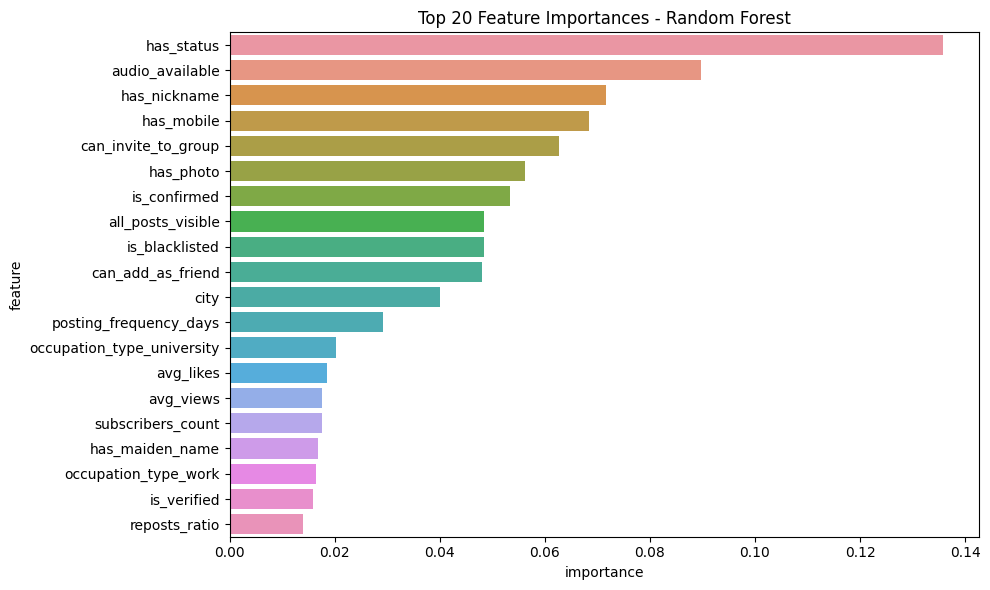

In [14]:
# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20))
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

## Train XGBoost model

In [15]:
# Initialize XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test)

# Results
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.98      0.96      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175

Confusion Matrix:
 [[575  13]
 [ 23 564]]


In [16]:
# Create TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb)

# Sample a subset of data for SHAP
X_sample = X_test.sample(200, random_state=42)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

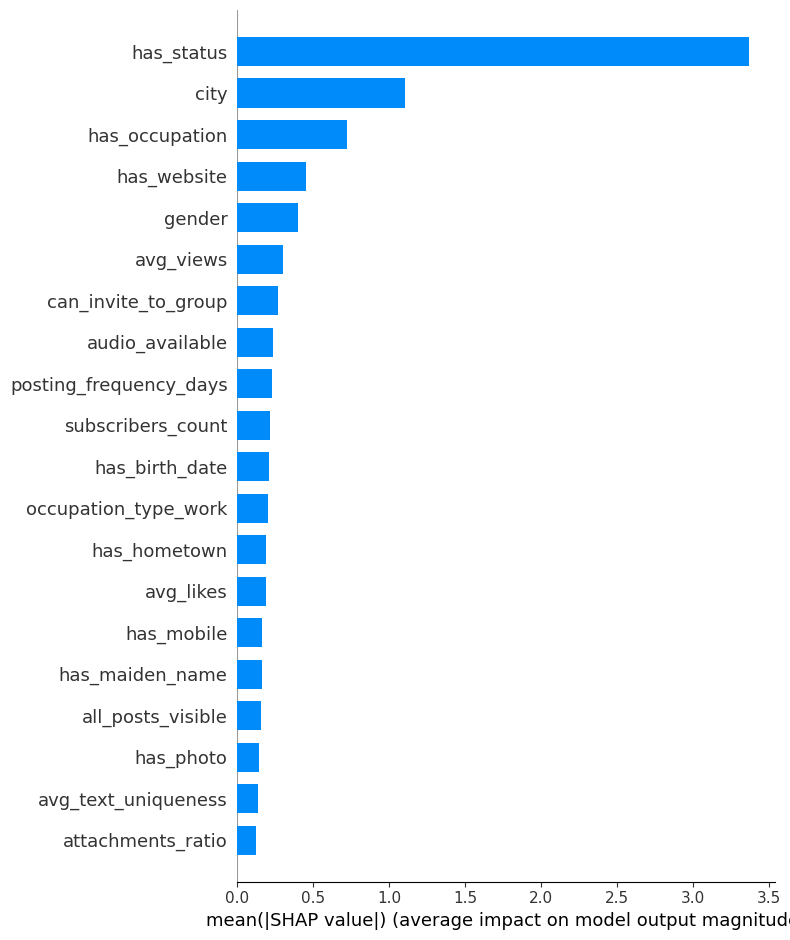

In [17]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_sample, plot_type="bar")

- **has_status** is by far the most important feature — bots likely don't set statuses as often.
- **city** is also strong — real users have geolocation more consistently.
- **has_occupation**, **has_website**, **gender** — all signs of profile richness.
- **Activity-based features** like avg_views, posting_frequency_days, and attachments_ratio have smaller but consistent impact.
- **Identity > Behavior** — profile completeness is a stronger bot/human signal than engagement.

## Tuned XGBoost Model
### Hyperparameter tuning for XGBoost

In [18]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_iter=20,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [19]:
# Predict with best model
y_pred_best = best_model.predict(X_test)

# Evaluation
print("Tuned XGBoost Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.98      0.96      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175

Confusion Matrix:
 [[576  12]
 [ 24 563]]


## Catboost Model

In [20]:
# Initialize CatBoost (silent mode)
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Train the model
cat_model.fit(X_train, y_train)

# Predict
y_pred_cat = cat_model.predict(X_test)

# Evaluate
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_cat))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))

CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.98      0.96      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175

Confusion Matrix:
 [[578  10]
 [ 22 565]]


- Fewer false positives (only 10 instead of 13–16 earlier)
- Strong precision for both classes
- Clean and stable confusion matrix

## Voting Classifier

In [21]:
# Wrap CatBoost for scikit-learn compatibility
cat_model_sklearn = CatBoostClassifier(verbose=0, random_state=42)

# Voting Classifier (hard voting)
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
        ('cat', cat_model_sklearn),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='hard', 
    n_jobs=-1
)

# Train the ensemble
voting_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_ensemble = voting_clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Voting Ensemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))

Voting Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.98      0.96      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175

Confusion Matrix:
 [[577  11]
 [ 22 565]]


# Pipeline
**This will:**
- Handle preprocessing
- Train the ensemble

In [22]:
# Recreate clean train/test
X = df.drop('target', axis=1)
y = df['target']

# Define numeric + categorical columns again
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Final model pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', voting_clf)
])

# Fit full pipeline
final_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred_pipeline = final_pipeline.predict(X_test)
print("Final Pipeline Classification Report:\n", classification_report(y_test, y_pred_pipeline))

Final Pipeline Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.98      0.96      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175



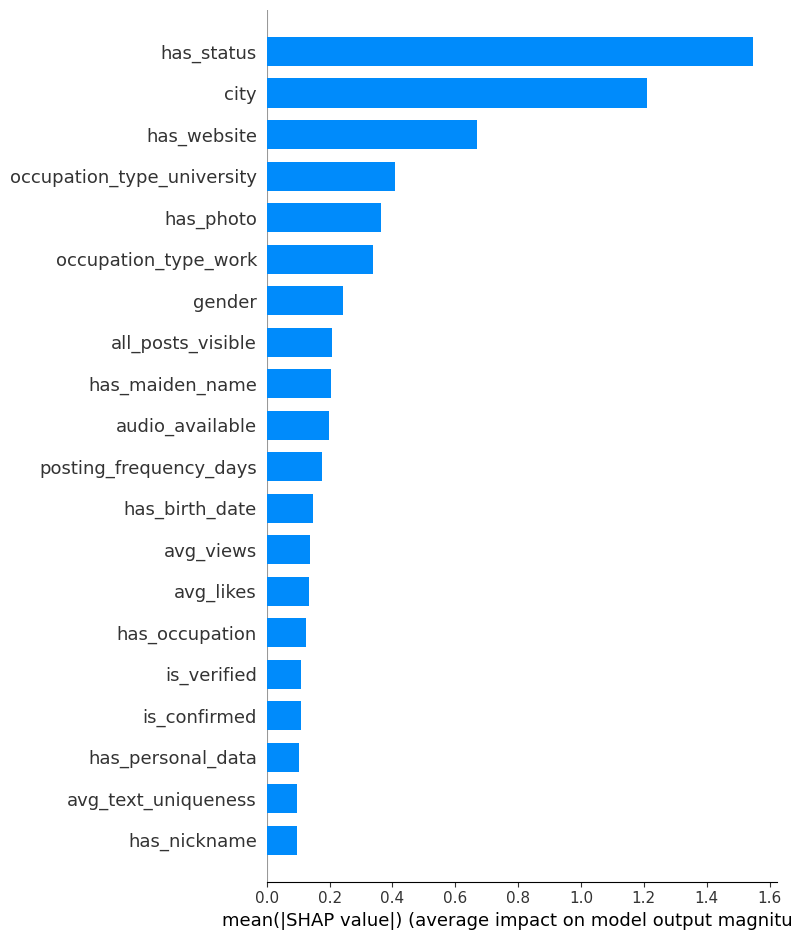

In [23]:
# Create explainer for CatBoost
explainer = shap.TreeExplainer(cat_model)

# Sample a subset of test data for speed
X_sample = X_test.sample(200, random_state=42)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_sample, plot_type='bar')

```Key Global Insights:```
- **has_status** and **city** dominate — major drivers of bot vs human prediction.

- Web presence (**has_website**), education/work (**occupation_type_***), and profile completeness features (e.g., **has_photo**, **has_birth_date**, etc.) are all important.

- Engagement/activity metrics (**avg_views**, **posting_frequency_days**) play a secondary role — not as impactful as identity-type features.

# ✅ Final Results Summary

In this notebook, we tackled the task of distinguishing between **genuine users and bots** on VK.com using profile metadata and behavioral features. Here's a summary of the steps and results:

---

### 🧪 **Approach:**
1. **Minimal EDA** with a focus on feature types and missing value treatment
2. Label encoding for categorical variables and imputation for numerical features
3. Trained multiple models:  
   - **Random Forest**  
   - **XGBoost**  
   - **CatBoost**
4. Built a **Voting Ensemble** combining all three models
5. Wrapped the best-performing pipeline using `scikit-learn`’s `Pipeline`
6. Added **model explainability** using **SHAP** on the CatBoost model

---

### 🎯 **Best Model Performance (Voting Ensemble):**
- **Accuracy:** 97%
- **Precision:** 0.96 (Class 0), 0.98 (Class 1)
- **Recall:** 0.98 (Class 0), 0.96 (Class 1)
- Balanced and robust across both classes

---

### 🔍 **Top Predictive Features (via SHAP):**
- `has_status`
- `city`
- `has_website`
- `occupation_type_university`
- `has_photo`, `gender`, `all_posts_visible`
  
These features suggest that **profile completeness, network openness, and professional metadata** are key signals for detecting bots.

---

### 🧠 **Key Takeaway:**
Using tree-based models with minimal preprocessing and a balanced dataset, it's possible to build a highly accurate and interpretable solution for bot detection. **CatBoost and SHAP** provided the best blend of performance and explainability.